In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    lives = obs[2:9,52:59]
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype(np.uint8) / 255
    obs[obs > 0] = 1
    return [obs,lives]

Welcome to AI Breakout!
Starting Test Game...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


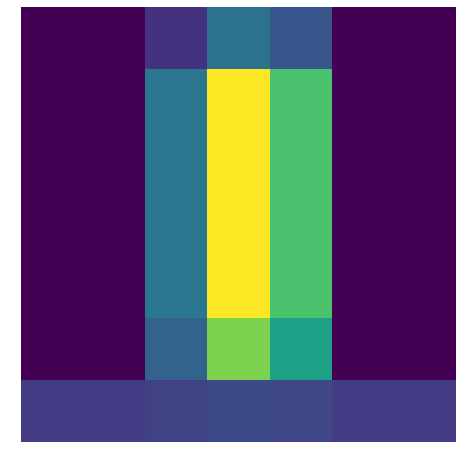

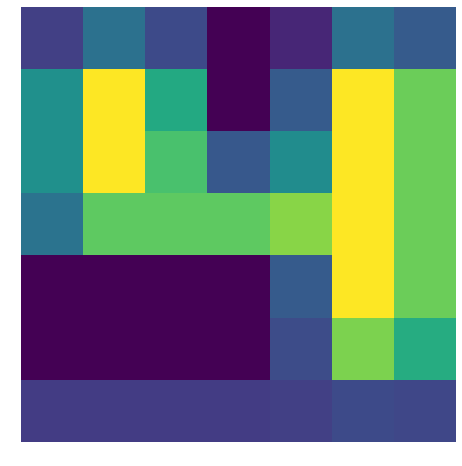

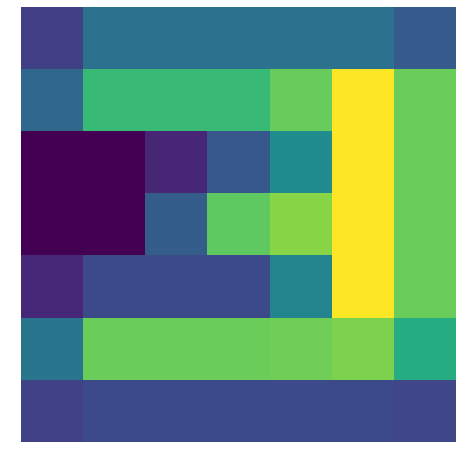

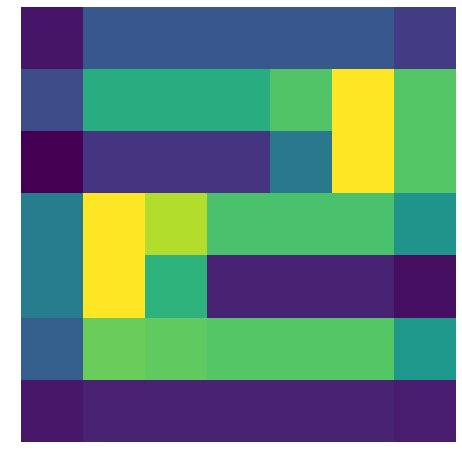

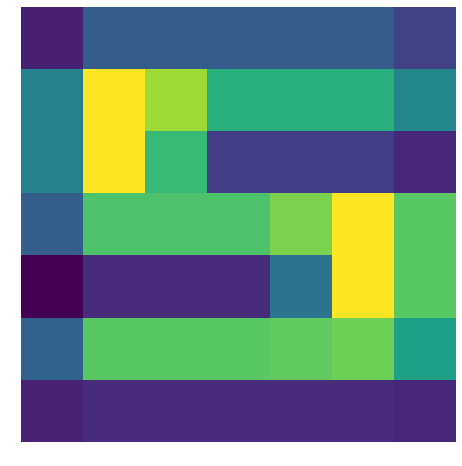

In [4]:
episodes = 1
env = gym.make("Breakout-v0")
init = env.reset()

for i in range(episodes):
    print("Welcome to AI Breakout!")
    print("Starting Test Game...\n")

    
    game = True
    LIVES = []
    while game:
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        LIVES.append(lives)
        
        if done:
            
            LIVES = np.unique(np.array(LIVES), axis=0)
            
            for i in LIVES:
                plot_state(i.reshape(7,7))
            game = False
            observation = env.reset()
                             
        else:
            pass
            
         

In [5]:
env = gym.make("Breakout-v0")
init = env.reset()

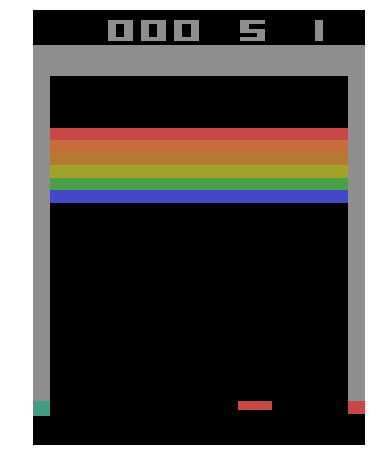

In [6]:
plot_state(init)

In [7]:
init.shape

(210, 160, 3)

In [8]:
I = process_obs(init)[0]

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [9]:
I.shape

(84, 84, 1)

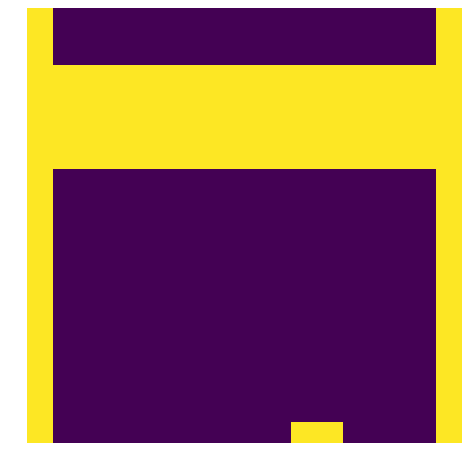

In [10]:
plot_state(I.reshape(84,84))

In [11]:
env.action_space

Discrete(4)

In [12]:
inp = Input(shape=(84,84,4))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,4))(inp)
x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(256,  activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.01, patience=2, mode = min, verbose = 1)]
model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               663808    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_________________________________________________________________
None

/Users/samwilliams/homebrew/lib/python3.7/site-packages/keras/callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [13]:
LIFE = {}
LIFE["1"] = LIVES[0]
LIFE["2"] = LIVES[3]
LIFE["3"] = LIVES[2]
LIFE["4"] = LIVES[1]
LIFE["5"] = LIVES[4]

In [14]:
for i,j in LIFE.items():
    print(i)

1
2
3
4
5


In [15]:
full_episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

In [ ]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 500
episode_scores = []
epsilon = 1
gamma = 0.99
done = False

for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    LIVES = []
    observation_batch = []
    reward_batch = []
    episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

    
    
    while game: 
        
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                rand = np.random.uniform(0,1)
                if  rand < epsilon:
                    action = env.action_space.sample()
                else:
                    observation = np.expand_dims(episode_history["state"][-1],0)
                    action = np.argmax(model.predict(observation))
                
                if len(episode_history["state"]) > 2:
                    if np.array_equal(episode_history["state"][-1], episode_history["state"][-2]):
                        action = 1
                    else:
                        pass
                else:
                    pass
                observation_batch = []
                reward_batch = []
                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        
        if len(LIVES) == 0:
            LIVES.append(lives)
            loss = 0
        else:
            if np.array_equal(LIVES[-1], lives):
                loss = 0
            else:
                LIVES.append(lives)
                loss = -10
                
        observation_batch.append(observation)
        reward_batch.append(10*reward+loss)        
        
        if (frame % 4 == 0):
            if frame == 4:
                episode_history["state"] = np.concatenate([i for i in observation_batch], axis=-1)
                episode_history["state"] = np.expand_dims(episode_history["state"],0)

            else:
                obs = np.concatenate([i for i in observation_batch], axis=-1)
                obs = np.expand_dims(obs,0)
                episode_history["state"] = np.concatenate([episode_history["state"], obs], axis=0)

            episode_history["reward"] = np.concatenate([episode_history["reward"], np.array([np.sum(reward_batch)])], axis = 0)  
            episode_history["action"] = np.concatenate([episode_history["action"], np.array([action])], axis=0)
         
        sum += reward
        frame += 1
        
        
        
        
        if done:

            for j,k in enumerate(episode_history["reward"][::-1]):
                
                if j == 0:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1])] = k
                    Q = val
                else:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1-j])] = k + gamma*np.sum(Q[-1])
                    Q = np.concatenate([Q,val], axis = 0)
                    
            Q = Q[::-1]
            episode_history["Q"] = Q
                        
            if i == 1:
                full_episode_history["state"] = episode_history["state"]
                full_episode_history["Q"] = episode_history["Q"]
            else:
                full_episode_history["state"] = np.concatenate([full_episode_history["state"], episode_history["state"]], axis = 0)
                full_episode_history["Q"] = np.concatenate([full_episode_history["Q"], episode_history["Q"]], axis = 0)

            full_episode_history["reward"] = np.concatenate([full_episode_history["reward"], episode_history["reward"]], axis = 0)
            full_episode_history["action"] = np.concatenate([full_episode_history["action"], episode_history["action"]], axis = 0)
            
            
            print("Training the model from a random batch...")
            
            rand = np.random.choice([i for i in range(full_episode_history["action"].shape[0])], size=32)
            inp = full_episode_history["state"][rand]
            target = full_episode_history["Q"][rand]
            model.fit(inp, target, epochs = 3, batch_size=32, verbose=1)
            print("Total game score was: {}".format(int(sum)))
            print("Epsilon: {}\n".format(epsilon))
            
            observation = env.reset()
            observation, lives = process_obs(observation)
            episode_scores.append(int(sum))
            epsilon *= 0.999
            if epsilon < 0.1:
                epsilon = 0.1
            game = False
            frame = 0
 
                             
        else:
            pass
            
         

Welcome to AI Breakout!
Starting Game 1 of 500...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 9ms/step - loss: 45.2378 - mean_absolute_error: 2.7985
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 42.7578 - mean_absolute_error: 2.9257
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 39.8458 - mean_absolute_error: 3.1799
Total game score was: 2
Epsilon: 1

Welcome to AI Breakout!
Starting Game 2 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 39.1049 - mean_absolute_error: 3.5808
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 35.4356 - mean_absolute_error: 3.3923
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 34.0282 - mean_absolute_error: 3.5613
Total game score was: 2
Epsilon: 0.999

Welcome to AI Breakout!
Starting Game 3 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [=========================

Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 63.7276 - mean_absolute_error: 5.4624
Total game score was: 0
Epsilon: 0.9831353223738244

Welcome to AI Breakout!
Starting Game 19 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 92.9063 - mean_absolute_error: 6.3716
Epoch 2/3
32/32 [==============================] - 0s 985us/step - loss: 89.8242 - mean_absolute_error: 6.7965
Epoch 3/3
32/32 [==============================] - 0s 980us/step - loss: 88.2467 - mean_absolute_error: 6.8467
Total game score was: 0
Epsilon: 0.9821521870514506

Welcome to AI Breakout!
Starting Game 20 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 85.0008 - mean_absolute_error: 6.9027
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 83.5408 - mean_absolute_error: 6.2376
Epoch 3/3
32/32 [==============================]

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 57.9384 - mean_absolute_error: 4.7791
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 55.4918 - mean_absolute_error: 4.0445
Epoch 3/3
32/32 [==============================] - 0s 994us/step - loss: 55.1326 - mean_absolute_error: 3.9163
Total game score was: 1
Epsilon: 0.9655885070369844

Welcome to AI Breakout!
Starting Game 37 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 65.9848 - mean_absolute_error: 4.2330
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 65.3186 - mean_absolute_error: 4.5029
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 64.9322 - mean_absolute_error: 4.6818
Total game score was: 3
Epsilon: 0.9646229185299474

Welcome to AI Breakout!
Starting Game 38 of 500...

Training the model from a random batch...
Epoch 1/

Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 68.1422 - mean_absolute_error: 4.7147
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 66.9841 - mean_absolute_error: 4.9981
Total game score was: 1
Epsilon: 0.9493041681462656

Welcome to AI Breakout!
Starting Game 54 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 52.4665 - mean_absolute_error: 4.5397
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 51.7613 - mean_absolute_error: 4.1817
Epoch 3/3
32/32 [==============================] - 0s 979us/step - loss: 51.5593 - mean_absolute_error: 4.0707
Total game score was: 0
Epsilon: 0.9483548639781193

Welcome to AI Breakout!
Starting Game 55 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 66.2170 - mean_absolute_error: 4.7195
Epoch 2/3
32/32 [==============================] -

Total game score was: 4
Epsilon: 0.933294459381294

Welcome to AI Breakout!
Starting Game 71 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 55.3376 - mean_absolute_error: 4.9794
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 54.1695 - mean_absolute_error: 4.7171
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 53.8741 - mean_absolute_error: 4.7595
Total game score was: 1
Epsilon: 0.9323611649219127

Welcome to AI Breakout!
Starting Game 72 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 61.9852 - mean_absolute_error: 5.0037
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 60.5069 - mean_absolute_error: 5.0539
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 59.5690 - mean_absolute_error: 5.1156
Total game score was: 2
Epsilon: 0.9314288037569908



Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 43.8547 - mean_absolute_error: 3.4827
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 43.0152 - mean_absolute_error: 3.4702
Total game score was: 2
Epsilon: 0.9166371944443392

Welcome to AI Breakout!
Starting Game 89 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 40.2370 - mean_absolute_error: 3.7199
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 40.1103 - mean_absolute_error: 3.7426
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 40.0284 - mean_absolute_error: 3.7557
Total game score was: 0
Epsilon: 0.9157205572498949

Welcome to AI Breakout!
Starting Game 90 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 83.9715 - mean_absolute_error: 5.1283
Epoch 2/3
32/32 [==============================] - 0

Total game score was: 1
Epsilon: 0.9011784036598737

Welcome to AI Breakout!
Starting Game 106 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 33.0304 - mean_absolute_error: 3.5680
Epoch 2/3
32/32 [==============================] - 0s 928us/step - loss: 32.7743 - mean_absolute_error: 3.4971
Epoch 3/3
32/32 [==============================] - 0s 901us/step - loss: 32.6499 - mean_absolute_error: 3.4941
Total game score was: 1
Epsilon: 0.9002772252562138

Welcome to AI Breakout!
Starting Game 107 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 57.7179 - mean_absolute_error: 4.1636
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 57.3305 - mean_absolute_error: 3.9492
Epoch 3/3
32/32 [==============================] - 0s 910us/step - loss: 57.1697 - mean_absolute_error: 3.8858
Total game score was: 1
Epsilon: 0.899376948

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 36.8012 - mean_absolute_error: 4.0993
Epoch 2/3
32/32 [==============================] - 0s 925us/step - loss: 36.2463 - mean_absolute_error: 3.8004
Epoch 3/3
32/32 [==============================] - 0s 915us/step - loss: 36.0819 - mean_absolute_error: 3.7859
Total game score was: 2
Epsilon: 0.88509434007808

Welcome to AI Breakout!
Starting Game 124 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 57.8394 - mean_absolute_error: 4.4779
Epoch 2/3
32/32 [==============================] - 0s 929us/step - loss: 57.1486 - mean_absolute_error: 4.3997
Epoch 3/3
32/32 [==============================] - 0s 902us/step - loss: 56.8812 - mean_absolute_error: 4.4357
Total game score was: 2
Epsilon: 0.8842092457380019

Welcome to AI Breakout!
Starting Game 125 of 500...

Training the model from a random batch...
Ep

Epoch 2/3
32/32 [==============================] - 0s 914us/step - loss: 78.6362 - mean_absolute_error: 4.8353
Epoch 3/3
32/32 [==============================] - 0s 870us/step - loss: 77.4380 - mean_absolute_error: 5.1833
Total game score was: 3
Epsilon: 0.8701675093639105

Welcome to AI Breakout!
Starting Game 141 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 49.5629 - mean_absolute_error: 4.3781
Epoch 2/3
32/32 [==============================] - 0s 925us/step - loss: 48.6346 - mean_absolute_error: 4.0196
Epoch 3/3
32/32 [==============================] - 0s 922us/step - loss: 48.3232 - mean_absolute_error: 3.9365
Total game score was: 3
Epsilon: 0.8692973418545467

Welcome to AI Breakout!
Starting Game 142 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 1ms/step - loss: 43.8261 - mean_absolute_error: 4.0608
Epoch 2/3
32/32 [=========================

In [ ]:
print(full_episode_history["state"].shape)
print(episode_history["reward"].shape)
print(episode_history["action"].shape)
print(episode_history["Q"].shape)

In [ ]:
z = np.array([[-2.1556249 , -5.4183836 , -0.28103527, -1.5402354 ]])

In [ ]:
np.argmax(z)

In [ ]:
print(episode_history["reward"][:])

In [ ]:
print(episode_history["action"])

In [ ]:
print(episode_history["Q"][10])

In [ ]:
model.predict(np.expand_dims(episode_history["state"][50],0))

In [ ]:
plt.figure(figsize=(17,11))
plt.plot(episode_scores)
plt.show()

# Saving Model

In [ ]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [ ]:
mod = load_model("breakout-atari-rl.h5")

In [ ]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 5
done = False
epsilon = 0


for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    frame = 0
    game = True
    obs = []
    while game:
        
        if (len(obs) == 0):
            action = 1
        elif (len(obs) > 1) and (np.array_equal(obs[-1],obs[-2])):
            action = 1
        
        else:
            if (frame % 4 == 0):
                rand = np.random.uniform(0,1)
                if  rand < epsilon:
                    action = env.action_space.sample()
                else:
                    observation = np.expand_dims(observation,0)
                    action = np.argmax(model.predict(observation))
            else:
                pass
            
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        obs.append(observation)

        sum += reward
        frame += 1
        time.sleep(0.03)
        env.render()

        if done:
            print("Total game score was: {}\n".format(int(sum)))
            observation = env.reset()
            observation, lives = process_obs(observation)
            game = False
env.close()        